In [1]:
%load_ext autoreload
%autoreload 2

from hydramuscle.model.smc import SMC
from hydramuscle.model.force_encoder_ecto import ForceEncoderEcto
from hydramuscle.model.force_encoder_endo import ForceEncoderEndo
from hydramuscle.utils import plot

In [17]:
# Define single-cell model
# model = SMC(T=100, 
#             dt=0.0002, 
#             k_ipr=0.1, 
#             s0=100, 
#             d=20e-4, 
#             v_delta=0,
#             k_deg=0.05)
model = SMC(T=100, 
            dt=0.0002, 
            k_ipr=0.02, 
            s0=100, 
            d=20e-4, 
            k_deg=0.05)

100%|██████████| 10000/10000 [00:00<00:00, 21627.77it/s]


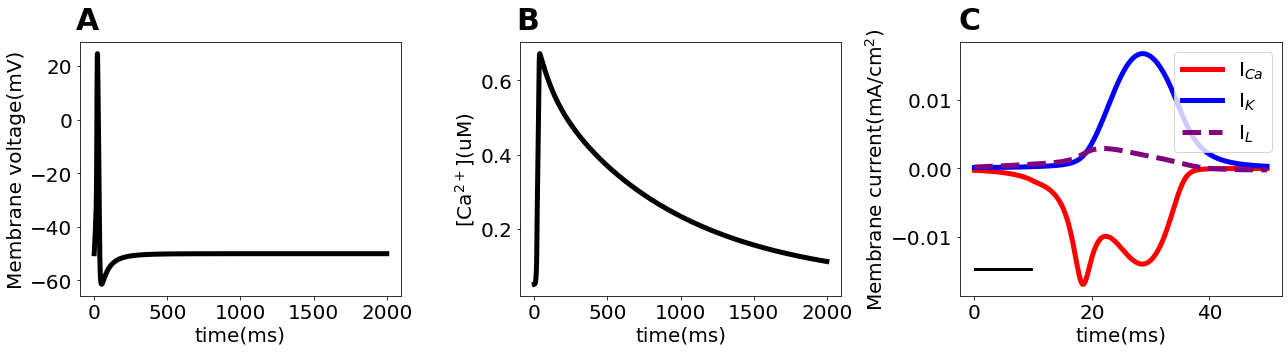

In [3]:
# Plot results of one fast spike
sol = model.run(stims_fast = [0], 
                stims_slow = [-100],
                T=2,
                dt=0.0002)
plot.plot_single_spike(model, sol, 0, 2, 0, 0.05, full_cell=True, 
#                        fontsize=15, textsize=20,
                       fontsize=20, textsize=30,
                       save_fig=True, save_path="./results/figures/fast-pathway.png")

100%|██████████| 500000/500000 [00:36<00:00, 13606.25it/s]


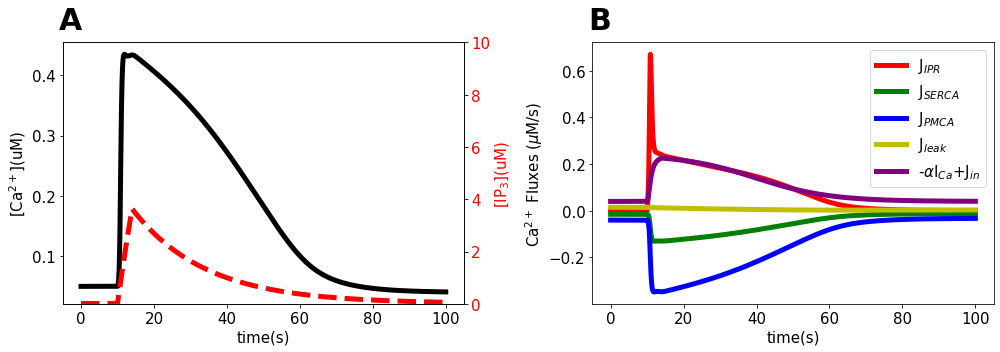

In [18]:
# Plot results of one slow transient
sol = model.run(stims_fast = [-100], 
                stims_slow = [10],
                T=100,
                dt=0.0002)
plot.plot_slow_transient(model, sol, 0, 100, full_cell=True, 
                         fontsize=15, textsize=30,
                         save_fig=True, save_path="./results/figures/slow-pathway.png")

In [10]:
# Plot multiple fast spikes
model = SMC(T=400, 
            dt=0.0002, 
            k_ipr=0.05, 
            s0=100, 
            d=20e-4, 
            k_deg=0.05)
init1=100
init2=223
sol = model.run(stims_fast=[0.0, 9.25, 14.5, 18.25, 21.5, 24.5, 28.0, 31.5, 35.25, 40.5,
                  init1+0.0, init1+9.25, init1+14.5, init1+18.25, init1+21.5, init1+24.5, init1+28.0, init1+31.5, init1+35.25, init1+40.5,
                  init2+0.0, init2+7.75, init2+15.25, init2+19.75, init2+23.0, init2+27.25, init2+30.5, init2+34.25, init2+38.25, init2+43.5], 
                stims_slow=[-100])

100%|██████████| 2000000/2000000 [01:34<00:00, 21128.21it/s]


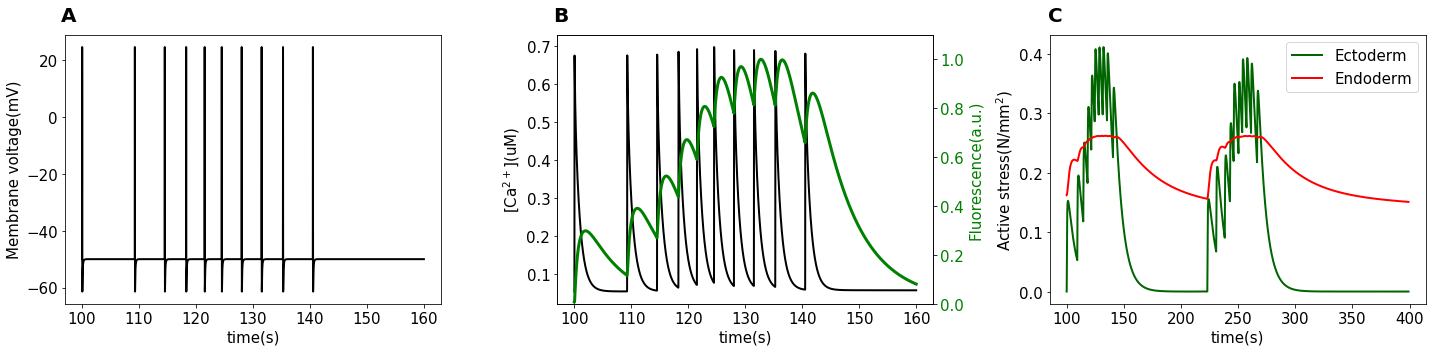

In [16]:
force_ecto = ForceEncoderEcto.encode(sol[:, 0], model.dt);
force_endo = ForceEncoderEndo.encode(sol[:, 0], model.dt);
plot.plot_multiple_spikes(model, sol, force_ecto, force_endo,
                          fontsize=15, textsize=20,
                          tmin1=100, tmax1=160, tmin2=100, tmax2=399, 
                          save_fig=True, save_path="./results/figures/multiple-fast.png")
# plt.figure(figsize=(20,3))
# plt.plot(force_ecto, 'g')
# plt.plot(force_endo, 'r')
# plt.show()